In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot')
import dateutil.parser
import re
import time

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
datestring = time.strftime("%m-%h-%d")
datestring

'07-Jul-24'

# Functions for Scraper

In [4]:
#Function to pick every other player (because of duplicates):
def removing_every_other_player(x):
    return x[::2]

In [5]:
#Functions for visiting players profil page:
def alter(player):
    try:
        return player.find('th', text = re.compile('Alter:')).findNext('td').string
    except:
        return None

In [6]:
def im_team_seit(player):
    try:
        return player.find('th', text = re.compile('Im Team seit:')).findNext('td').string.strip()
    except:
        return None

In [7]:
def position(player):
    if player == None:
        return None
    else:
        return player.find('th', text = re.compile('Position:'))\
    .findNext('td').string.strip()

In [8]:
def groesse(player):
    try:
        return int(player.find('th', text = re.compile('Größe:')).findNext('td').string.replace(',', '').replace(' m', ''))
    except:
        return None

In [9]:
def club(player):
    if player.find('th', text = re.compile('Aktueller Verein:')).string.strip() == 'Aktueller Verein:':
        return player.find('th', text = re.compile('Aktueller')).findNext('td').findNext('a').find('img').get('alt')
    elif player.find('th', text = re.compile('Current club:')).string.strip() == 'Current club:':
        return player.find('th', text = re.compile('Current club:')).findNext('td').findNext('a').find('img').get('alt')
    else:
        return

In [10]:
#Function to extract the former club:
def ex_club(player):
    try:
        return player.find('td', {'class': 'hauptlink no-border-links hide-for-small vereinsname'}).findNext('a').string
    except:
        return None

In [11]:
def agent(player):
    try:
        return player.find('th', text = re.compile("Spielerberater:"))\
    .findNext('td').findNext('a').get('title')
    except:
        return None

In [12]:
def marktwert(player):
    try:
        return player.find('div', {'class': 'right-td'}).findNext('a').text.replace(',', '').replace(' Mio. €', '0000').replace(' Tsd. €', '0000')
    except:
        return None

In [13]:
def shoes(player):
    try:
        return player.find('th', text = re.compile("Ausrüster:")).findNext('td')\
    .findNext('a').findNext('img').get('title')
    except:
        return None

In [14]:
def ausgeliehen_von(player):
    try:
        return player.find('th', text = re.compile("Ausgeliehen von:")).findNext('td').find('a').text
    except:
        return None

In [15]:
def Minuten(x):
    try:
        return int(x.find('td', {'class': 'zentriert'}).find_next('td', {'class': 'rechts'}).string.replace("'", ''))
    except:
        return None

# Scraping

In [16]:
#This site doesn't like to be scraped, therefore I'll use this header:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [17]:
#url = "http://www.transfermarkt.com/raiffeisen-super-league/transfers/wettbewerb/C1/saison_id/2017"
url = "http://www.transfermarkt.ch/raiffeisen-super-league/transfers/wettbewerb/C1/saison_id/2017"
response = requests.get(url, headers=headers)
transfermarkt_soup = BeautifulSoup(response.text, 'html.parser')

In [18]:
transfermarkt = transfermarkt_soup.find_all('a', {'class': 'spielprofil_tooltip'})

In [19]:
#not what that does - have to check again.
transfermarkt.pop(0)
#Only picking every other player
transfermarkt = removing_every_other_player(transfermarkt)

In [20]:
transfer_dict = []

for spieler in transfermarkt:
    
    #Name
    Name = spieler.string
    print(Name)
    
    #Link
    spieler_link = spieler['href']
    spieler_link = 'http://www.transfermarkt.ch' + spieler_link
    #print(spieler_link)
    
    #Visiting players profil pages
    spieler_profil = requests.get(spieler_link, headers=headers)
    spieler_profil = BeautifulSoup(spieler_profil.text, 'html.parser')
    #print(spieler_profil)
    
    Alter = alter(spieler_profil)
    #print(Alter)
    Grösse = groesse(spieler_profil)
    #print(Grösse)
    Position = position(spieler_profil)
    #print(Position)
    Verein = club(spieler_profil)
    #print(Verein)
    Ex_Verein = ex_club(spieler_profil)
    #print(Ex_Verein)
    Agent = agent(spieler_profil)
    #print(Agent)
    Ausrüster = shoes(spieler_profil)
    #print(Ausrüster)
    Im_team_seit = im_team_seit(spieler_profil)
    #print(Im_team_seit)
    Marktwert = marktwert(spieler_profil)
    Ausgeliehen_von = ausgeliehen_von(spieler_profil)
    #print(Marktwert)

    #Visiting Leistungsdaten pages
    spieler_leistungsdaten_link = spieler_link.replace('profil', 'leistungsdaten')
    spieler_leistungsdaten_link = spieler_leistungsdaten_link + '/plus/0?saison=ges'
    spieler_leistungsdaten = requests.get(spieler_leistungsdaten_link, headers=headers)
    spieler_leistungsdaten = BeautifulSoup(spieler_leistungsdaten.text, 'html.parser')
    print(spieler_leistungsdaten_link)
    
    #This is possible to do in a list because every player has these parameters
    Spiele = spieler_leistungsdaten.find('tfoot')
    leistungsdaten = Spiele.find_all('td', {'class': 'zentriert'})
    leistungsdaten_list = []
    for Daten in leistungsdaten:
        Daten = Daten.string
        leistungsdaten_list.append(Daten)
    
    if len(leistungsdaten_list) > 6:
        Totalspiele = int(leistungsdaten_list[0].replace('-', '0'))
        Tore = int(leistungsdaten_list[1].replace('-', '0'))
        Vorlagen = 0
        Gelbe_Karten = int(leistungsdaten_list[2].replace('-', '0'))
        Gelb_Rote_Karten = int(leistungsdaten_list[3].replace('-', '0'))
        Rote_Karten = int(leistungsdaten_list[4].replace('-', '0'))
    
    else:
        Totalspiele = int(leistungsdaten_list[0].replace('-', '0'))
        Tore = int(leistungsdaten_list[1].replace('-', '0'))
        Vorlagen = int(leistungsdaten_list[2].replace('-', '0'))
        Gelbe_Karten = int(leistungsdaten_list[3].replace('-', '0'))
        Gelb_Rote_Karten = int(leistungsdaten_list[4].replace('-', '0'))
        Rote_Karten = int(leistungsdaten_list[5].replace('-', '0'))
        #print(leistungsdaten_list)
        
#Minuten = Minuten(Spiele)
    
    Spieler_Dict = {"Name": Name,
                    "Alter": Alter,
                    "URL": spieler_link,
                    "Grösse": Grösse,
                    "Position": Position,
                    "Verein": Verein,
                    "Wechsel von": Ex_Verein,
                    "Ausgeliehen von": Ausgeliehen_von,
                    "Agent": Agent,
                    "Ausrüster": Ausrüster,
                    "Im Team seit": Im_team_seit,
                    "Total Spiele": Totalspiele,
                    "Tore": Tore,
                    "Vorlagen": Vorlagen,
                    "Gelbe Karten": Gelbe_Karten,
                    "Gelb-Rote Karten": Gelb_Rote_Karten,
                    "Rote Karten": Rote_Karten,
                    'Marktwert': Marktwert,
                    'Minuten': Minuten
                    }
    
    transfer_dict.append(Spieler_Dict)

R. van Wolfswinkel
http://www.transfermarkt.ch/ricky-van-wolfswinkel/leistungsdaten/spieler/41355/plus/0?saison=ges
F. Frei
http://www.transfermarkt.ch/fabian-frei/leistungsdaten/spieler/52595/plus/0?saison=ges
A. Ajeti
http://www.transfermarkt.ch/albian-ajeti/leistungsdaten/spieler/195906/plus/0?saison=ges
D. Oberlin
http://www.transfermarkt.ch/dimitri-oberlin/leistungsdaten/spieler/212718/plus/0?saison=ges
V. Stocker
http://www.transfermarkt.ch/valentin-stocker/leistungsdaten/spieler/45178/plus/0?saison=ges
L. Lacroix
http://www.transfermarkt.ch/leo-lacroix/leistungsdaten/spieler/149652/plus/0?saison=ges
S. Campo
http://www.transfermarkt.ch/samuele-campo/leistungsdaten/spieler/183446/plus/0?saison=ges
D. Nikolic
http://www.transfermarkt.ch/djordje-nikolic/leistungsdaten/spieler/274344/plus/0?saison=ges
S. Antonio
http://www.transfermarkt.ch/signori-antonio/leistungsdaten/spieler/147029/plus/0?saison=ges
N. Okafor
http://www.transfermarkt.ch/noah-okafor/leistungsdaten/spieler/346890/p

http://www.transfermarkt.ch/patrick-olsen/leistungsdaten/spieler/135217/plus/0?saison=ges
G. Sherko
http://www.transfermarkt.ch/gubari-sherko/leistungsdaten/spieler/295469/plus/0?saison=ges
N. Bahoui
http://www.transfermarkt.ch/nabil-bahoui/leistungsdaten/spieler/93184/plus/0?saison=ges
V. Fazliu
http://www.transfermarkt.ch/valon-fazliu/leistungsdaten/spieler/98167/plus/0?saison=ges
N. Loosli
http://www.transfermarkt.ch/noah-loosli/leistungsdaten/spieler/265209/plus/0?saison=ges
N. Hunziker
http://www.transfermarkt.ch/nicolas-hunziker/leistungsdaten/spieler/184193/plus/0?saison=ges
M. Dabbur
http://www.transfermarkt.ch/munas-dabbur/leistungsdaten/spieler/145866/plus/0?saison=ges
G. Chande
http://www.transfermarkt.ch/gion-chande/leistungsdaten/spieler/290013/plus/0?saison=ges
S. Rapp
http://www.transfermarkt.ch/simone-rapp/leistungsdaten/spieler/154635/plus/0?saison=ges
F. Margiotta
http://www.transfermarkt.ch/francesco-margiotta/leistungsdaten/spieler/165891/plus/0?saison=ges
D. Mesbah

KeyboardInterrupt: 

# Making a Dataframe and cleaning it

In [ ]:
#Making the DataFrame
df_transfers = pd.DataFrame(transfer_dict)

In [ ]:
df_transfers.head()

In [ ]:
df_transfers.shape

In [ ]:
#Test for one club:
df_transfers[df_transfers['Verein'] == 'BSC Young Boys'].head()

In [ ]:
#Dealing with the loan of players:
#1.) Sorting out only the loaned players. Moving column to the back. 
#2.) Deleting last club column. Renaming the loaned column. 
#3.) Concating it with the original file.
#So now the last club column is correct. 
df_ausgeliehen = df_transfers[df_transfers['Ausgeliehen von'].notnull()]

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

#moving column to the back
df = change_column_order(df_ausgeliehen, 'Ausgeliehen von', 17)

del df['Wechsel von']

#Renaming last column
df.columns = df.columns.str.replace('Ausgeliehen von','Wechsel von')

#Prepping original dataframe
df_transfers = df_transfers[df_transfers['Ausgeliehen von'].isnull()]

del df_transfers['Ausgeliehen von']

#concating the two
df_SL_transfers = pd.concat([df, df_transfers], ignore_index=True)

#Dropping any duplicate values
df_SL_transfers = df_SL_transfers.drop_duplicates()

In [ ]:
# Making sure all the clubs are spelt correctly:

#Dealing with the name problem of the Clubs (FCB, Grasshoppers etc.). Two different names for FCB, Lausanne, GC, FCSG in the columns.
def fcb_lausanne(x):
    return x.replace(' 1893', '').replace('Grasshoppers', 'Grasshopper Club Zürich').replace('Lausanne-Sport', 'FC Lausanne-Sport').replace('FC St. Gallen', 'FC St. Gallen 1879')

def fcb(x):
    return x.replace(' 1893', '')

df_SL_transfers['*Wechsel von*'] = df_SL_transfers['Wechsel von'].apply(fcb_lausanne)
df_SL_transfers['*Verein*'] = df_SL_transfers['Verein'].apply(fcb)

In [ ]:
df_SL_transfers.head()

In [ ]:
#Checking the dtypes:
df_SL_transfers.dtypes

In [ ]:
#Changing the datype of Marktwert to an float, but some '-' and ' ' that cause problems when trying to convert:
df_SL_transfers['Marktwert'].replace(['-', ' '], ['NaN', 'NaN'], inplace=True)

In [ ]:
#Test:
df_SL_transfers['Marktwert'].head()

In [ ]:
df_SL_transfers['Marktwert'] = df_SL_transfers.Marktwert.astype(float)

In [ ]:
df_SL_transfers.dtypes

In [ ]:
#Safeing dataframe:
df_SL_transfers.to_csv('SL_transfers.csv', index=False)

## Analyzing the data 

In [ ]:
#Shoes:
df_SL_transfers['Ausrüster'].value_counts()

In [ ]:
#Top 10 most active agents in Switzerland:
df_SL_transfers['Agent'].value_counts().head(10)

In [ ]:
#Biggest player agency:
soccer_mondial = df_SL_transfers[df_SL_transfers. Agent == 'SOCCER MONDIAL']
soccer_mondial.head()

In [ ]:
#Players with Soccer Mondial:
soccer_mondial.Name

In [ ]:
#Number of players with Soccer Mondial:
soccer_mondial.Name.count()

In [ ]:
#Market value of players with Soccer Mondial:
soccer_mondial.groupby('Name').Marktwert.value_counts()

In [ ]:
#How can I sum all the market values of the players from Soccer mondial?

# Creating Dataframes to establish gain, losses of each club

In [21]:
#Importing Super League Clubs
df_SL_Vereine = pd.read_csv("Super_League_Vereine_18_19.csv")

In [22]:
df_SL_Vereine.head(10)

,SL-Verein,Group 1,Group 2
0,FC Basel,FCB,FCB
1,FC Sion,Sion,Rest
2,FC Lugano,Lugano,Rest
3,FC Lausanne-Sport,Rest,Rest
4,BSC Young Boys,Rest,Rest
5,Grasshopper Club Zürich,Rest,Rest
6,FC Luzern,Rest,Rest
7,FC Zürich,Rest,Rest
8,FC St. Gallen 1879,Rest,Rest
9,FC Thun,Rest,Rest


In [ ]:
#Merging the Files
df_SL_Zuzuege = df_SL_transfers.merge(df_SL_Vereine, left_on = '*Verein*', right_on ='SL-Verein') 
df_SL_Abgaenge = df_SL_transfers.merge(df_SL_Vereine, left_on = '*Wechsel von*', right_on ='SL-Verein')

In [ ]:
#Having a look:
df_SL_Zuzuege.head()

In [ ]:
#Having a look:
df_SL_Abgaenge.head()

In [ ]:
#Working out total market values of bought players
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Marktwert'].sum())
Total_Marktwert_Zuzuege.tail(3)

In [ ]:
#Working out total market values of sold players
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Marktwert'].sum())
Total_Marktwert_Abgaenge.tail(3)

In [ ]:
#Resetting the Index of both the new frames
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [ ]:
#Merging the data sets
Zuzuege_Abgaenge = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*') 

In [ ]:
#Working out the difference
Zuzuege_Abgaenge['Transfer_Differenz_Marktwert'] = Zuzuege_Abgaenge['Marktwert_x'] - Zuzuege_Abgaenge['Marktwert_y']

In [ ]:
#Deleting the columns we don't need:
del Zuzuege_Abgaenge['*Wechsel von*']

In [ ]:
#del Zuzuege_Abgaenge['level_0']

In [ ]:
#del Zuzuege_Abgaenge['index']

In [ ]:
Zuzuege_Abgaenge.tail()

In [ ]:
#Renaming columns
Zuzuege_Abgaenge.columns = ['verein', 'gesamt_marktwert_zuzuege', 'gesamt_marktwert_abgaenge', 'gesamt_differenz_marktwert']

In [ ]:
Zuzuege_Abgaenge

In [25]:
#Safeing dataframe as csv:
Zuzuege_Abgaenge.to_csv('zuzuege_abgaenge_SL.csv', index=False)

NameError: name 'Zuzuege_Abgaenge' is not defined

In [ ]:
#For goals:
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Tore'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Tore'].sum())

In [ ]:
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [ ]:
#Merging the two frames:
Tore = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')

In [ ]:
#Working out the difference:
Tore['Transfer_Differenz_Tore'] = Tore['Tore_x'] - Tore['Tore_y']

In [ ]:
del Tore['*Wechsel von*']

In [ ]:
Tore.tail()

In [ ]:
#For Assists:

Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Vorlagen'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Vorlagen'].sum())
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)
Vorlagen = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')
Vorlagen['Transfer_Differenz_Vorlagen'] = Vorlagen['Vorlagen_x'] - Vorlagen['Vorlagen_y']
del Vorlagen['*Wechsel von*']

In [ ]:
Vorlagen.tail()

In [ ]:
#The minutes in total:
Total_Marktwert_Zuzuege = pd.DataFrame(df_SL_Zuzuege.groupby('*Verein*')['Total Spiele'].sum())
Total_Marktwert_Abgaenge = pd.DataFrame(df_SL_Abgaenge.groupby('*Wechsel von*')['Total Spiele'].sum())
#Resetting the Index of both the new frames
Total_Marktwert_Abgaenge.reset_index(inplace=True)
Total_Marktwert_Zuzuege.reset_index(inplace=True)

In [ ]:
#Merging the two frames:
Minuten = Total_Marktwert_Zuzuege.merge(Total_Marktwert_Abgaenge, left_on = '*Verein*', right_on ='*Wechsel von*')

In [ ]:
Minuten.tail()

In [ ]:
Minuten['Transfer_Differenz_Minuten'] = Minuten['Total Spiele_x'] - Minuten['Total Spiele_y']

In [ ]:
del Minuten['*Wechsel von*']

In [ ]:
Zuzuege_Abgaenge.tail()

In [ ]:
Minuten.tail()

In [ ]:
Zuzuege_Abgaenge.dtypes

In [ ]:
Tore.dtypes

In [ ]:
#Now merging Zuzuege_Abgaenge, Tore und Vorlagen und Minuten. 
#Deleting the columns I don't need and renaming the ones I do.
df_bilanz = Zuzuege_Abgaenge.merge(Tore, left_on = 'verein', right_on ='*Verein*')
df_bilanz = df_bilanz.merge(Vorlagen, left_on = 'verein', right_on ='*Verein*')
df_bilanz = df_bilanz.merge(Minuten, left_on = 'verein', right_on ='*Verein*')

In [23]:
df_bilanz.shape

NameError: name 'df_bilanz' is not defined

In [ ]:
#del df_transferbilanz['*Verein*_x']
#del df_transferbilanz['*Verein*_y']
#del df_transferbilanz['*Verein*']

In [ ]:
df_bilanz.tail(5)

In [ ]:
#Safeing merged dataframe as csv:
df_bilanz.to_csv('transferbilanz_SL.csv', index=False)

In [ ]:
df_bilanz.head()

In [ ]:
df_bilanz.drop(['*Verein*_x', '*Verein*_y', '*Verein*'], axis=1, inplace=True)

In [ ]:
df_bilanz.head(1)

In [ ]:
#import re
#dropper = [col for col in df_transferbilanz.columns if len(re.findall(r"_x", col))!=0]
#dropper

In [ ]:

df_bilanz.columns = ['verein', 'total_marktwert_zuzuege', 'total_marktwert_abgaenge', 'differenz_marktwert', 'total_tore_zuzuege', 'total_tore_abgaenge', 'tore_differenz', 'total_vorlagen_zuzuege', 'total_vorlagen_abgaenge', 'vorlagen-differenz', 'total_spiele_zuzuege', 'total_spiele_abgaenge', 'total-spiel-differenz']

In [ ]:
df_bilanz.head()

In [ ]:
#Safeing cleaned dataframe as csv:
df_bilanz.to_csv('transferbilanz_cleaned_SL.csv', index=False)

# Plotting 

### Most active player agents

NameError: name 'df_SL_transfers' is not defined

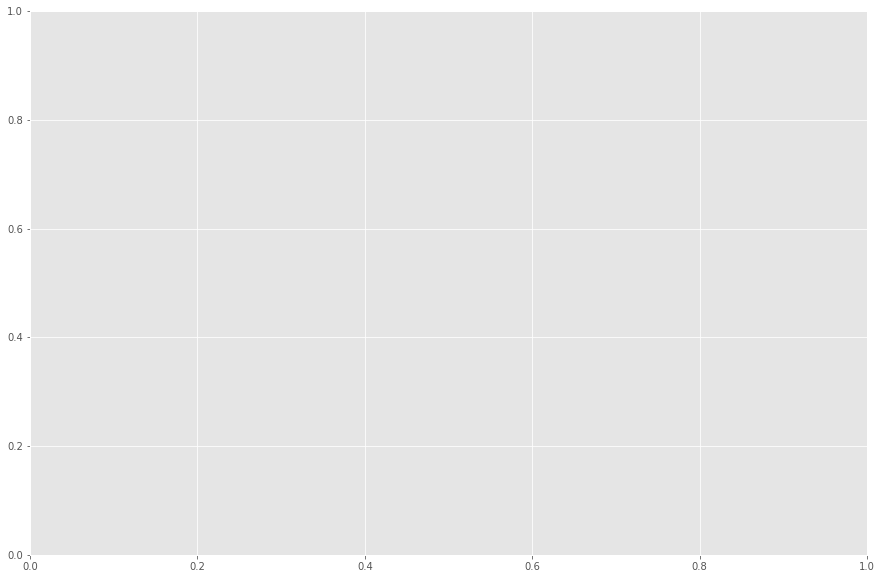

In [24]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_SL_transfers['Agent'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh', color= "#0C2340")

ax.set_facecolor("#EBEBEB")

ax.grid(which='major', linestyle='-', linewidth='0.5', color='darkgrey')
#Getting rid of the ax.y
ax.grid(False, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tick_params(
    #axis='x',
    top=False,
    which=False,
    left=False,
    right=False,
    bottom=False,
    labeltop=False,
    labelbottom=False)

#Labels and title
ax.set_xlabel('Players under contract', **csfont, fontsize=12)
ax.set_title("Ranking the Most Active Player Agents of the Swiss Football League ", **csfont, pad=40, fontsize=24)

plt.gcf().text(0.5, 0.9, "Football isn't only about Players and Coaches. These are the agencies that broker the most deals behind the scenes.", ha="center", fontsize=14)

ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax.set_xticklabels(["", 2, 4, 6, 8, 10, 12, 14, 16])




#Saving
plt.savefig('Agents.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Agents.png', transparent=True, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_SL_transfers['Agent'].value_counts().head(10).sort_values(ascending=True).plot(kind='barh', color= "#0C2340")

ax.set_facecolor("#EBEBEB")

ax.xaxis.grid(color='white', linestyle=':', linewidth=1)


ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tick_params(
    #axis='x',
    top=False,
    which=False,
    left=False,
    right=False,
    bottom=False,
    labeltop=False,
    labelbottom=False)

#Labels and title and subtitle
#ax.set_xlabel('Traded players under contract', **csfont, fontsize=12)
ax.set_title("Ranking the Most Active Player Agents of the Swiss Football League ", **csfont, pad=40, fontsize=24)

plt.gcf().text(0.5, 0.9, "Football isn't only about Players and Coaches. These are the agencies that broker the most deals behind the scenes.", ha="center", fontsize=14)

ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax.set_xticklabels(["", 2, 4, 6, 8, 10, 12, 14, 16])

# xticks & yticks have empty lists to reduce white space in plot
ax.grid(False)

ax.tick_params(left=False)
plt.xticks([])


#plt.yticks([])
#plt.tight_layout()

#Bars free:
for i, bar in enumerate(ax.patches):
    print(i)
    print(bar)
    
    #Now numbers inside of bars
    value = bar.get_width() -1
    x_pos = bar.get_width() -0.5
    y_pos = i
    ax.text(x_pos, y_pos, round(value,1), va='center', ha = "right", color="white", fontweight="bold")
    
#Legend   
ax.legend(loc='lower right', title='Number of traded players under contract ', frameon=False)


#Saving
plt.savefig('Agents_bars_free.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Agents_bars_free.png', transparent=True, bbox_inches='tight')

In [459]:
##Safing the dataframe in a new one and making the club name also the Index, useful when making the graphs
df_bilanz_new = df_bilanz
df_bilanz_new

,verein,total_marktwert_zuzuege,total_marktwert_abgaenge,differenz_marktwert,total_tore_zuzuege,total_tore_abgaenge,tore_differenz,total_vorlagen_zuzuege,total_vorlagen_abgaenge,vorlagen-differenz,total_spiele_zuzuege,total_spiele_abgaenge,total-spiel-differenz
verein,,,,,,,,,,,,,
BSC Young Boys,BSC Young Boys,63500000.0,70750000.0,-7250000.0,234,380,-146,119,257,-138,1283,2432,-1149
FC Basel,FC Basel,38000000.0,52250000.0,-14250000.0,552,441,111,258,262,-4,2126,2607,-481
FC Lausanne-Sport,FC Lausanne-Sport,42750000.0,34250000.0,8500000.0,255,424,-169,79,279,-200,1594,3216,-1622
FC Lugano,FC Lugano,76750000.0,34750000.0,42000000.0,502,242,260,191,170,21,2926,3052,-126
FC Luzern,FC Luzern,36750000.0,35500000.0,1250000.0,176,241,-65,134,117,17,1922,2644,-722
FC Sion,FC Sion,42350000.0,85750000.0,-43400000.0,172,579,-407,104,314,-210,1763,3548,-1785
FC St. Gallen 1879,FC St. Gallen 1879,43250000.0,40000000.0,3250000.0,229,265,-36,149,153,-4,1976,1994,-18
FC Thun,FC Thun,51250000.0,24000000.0,27250000.0,235,263,-28,128,80,48,1471,1494,-23
FC Zürich,FC Zürich,29000000.0,40000000.0,-11000000.0,130,253,-123,84,215,-131,1099,3159,-2060


In [429]:
df_bilanz_new.index = df_bilanz_new['verein']

In [540]:
from matplotlib.ticker import FuncFormatter

#Step 1: Build a function
def with_words(value, pos):
    millions = int(value/1000000)
   # print(pos)
    return "{} million".format(int(millions))

def with_commas(value, pos):
    return "{:,}".format(int(value))

#Step 2: Use FuncFormatter with that function
formatter = FuncFormatter(with_commas)

### Differenz der Spielermarktwerte 

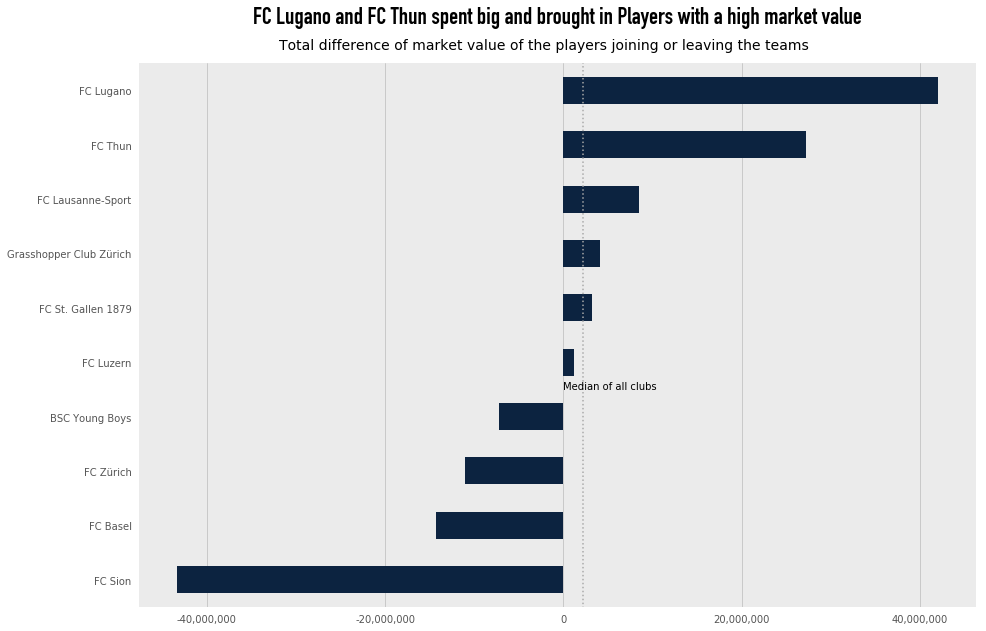

In [599]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_bilanz_new['differenz_marktwert'].sort_values().plot(kind='barh', ax = ax, legend=False, color=['#0C2340'])
plt.axes

ax.set_facecolor("#EBEBEB")


#grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='darkgrey')
#Getting rid of the ax.y
ax.grid(False, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


#Labels and title
ax.set_title("FC Lugano and FC Thun spent big and brought in Players with a high market value", **csfont, pad=40, fontsize=24)
plt.gcf().text(0.5, 0.9, "Total difference of market value of the players joining or leaving the teams", ha="center", fontsize=14)
ax.set_ylabel('')

#Ticks
ax.tick_params(left=False)
ax.tick_params(bottom=False)

#Showing Median
median = df_bilanz_new['differenz_marktwert'].median()
ax.plot([median, median], [-4, 10], c='darkgrey', linestyle=':')
ax.annotate(s='Median of all clubs', xy=(4000,3.5), color='black')

#Formatting x-labels 
#Step 1: Build a function
def with_words(value, pos):
    millions = int(value/1000000)
   # print(pos)
    return "{} million".format(int(millions))

def with_commas(value, pos):
    return "{:,}".format(int(value))

#Step 2: Use FuncFormatter with that function
formatter = FuncFormatter(with_commas)
ax.set_axisbelow(True)

ax.xaxis.set_major_formatter(formatter)

plt.savefig('Marktwerte.pdf', transparent=True, bbox_inches='tight')
plt.savefig('Marktwerte.png', transparent=True, bbox_inches='tight')



In [468]:
df_bilanz_new['total-spiel-differenz']

verein
BSC Young Boys            -1149
FC Basel                   -481
FC Lausanne-Sport         -1622
FC Lugano                  -126
FC Luzern                  -722
FC Sion                   -1785
FC St. Gallen 1879          -18
FC Thun                     -23
FC Zürich                 -2060
Grasshopper Club Zürich    -222
Name: total-spiel-differenz, dtype: int64

## Experience 

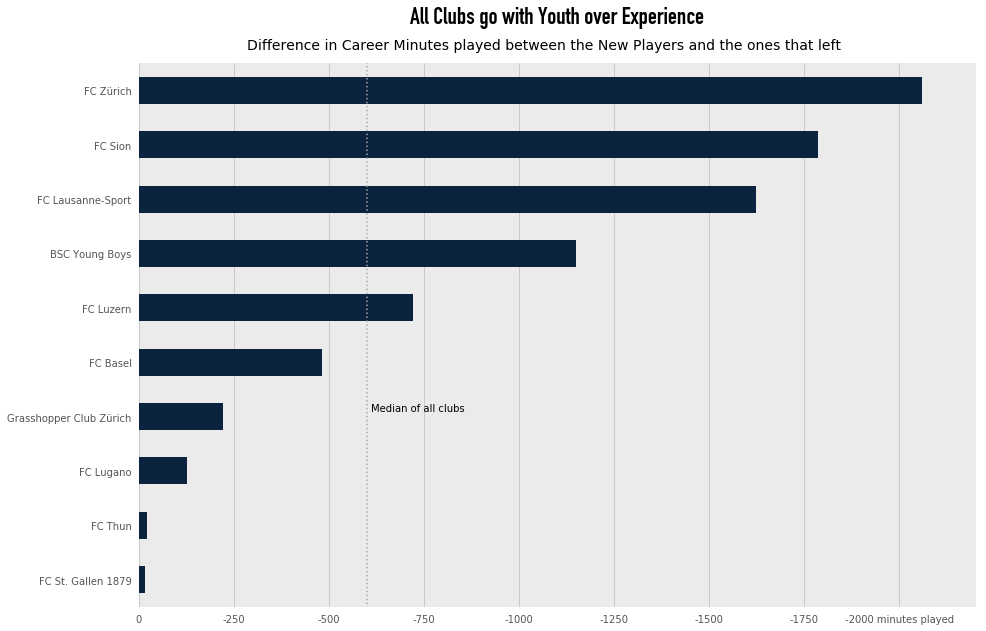

In [601]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

df_bilanz_new['total-spiel-differenz'].sort_values(ascending=False).plot(kind='barh', legend=False, ax = ax, color=['#0C2340'])
plt.axes

ax.set_facecolor("#EBEBEB")

ax.set_ylabel('')


#grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='darkgrey')
#Getting rid of the ax.y
ax.grid(False, axis='y')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


#Changing the lims of the bars (from right to left) to (left to right)
plt.xlim([ 0,-2200])


#Ticks
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.set_xticks([0, -250, -500, -750, -1000, -1250, -1500, -1750, -2000])
ax.set_xticklabels([0, -250, -500, -750, -1000, -1250, -1500, -1750, "-2000 minutes played"])

#Title
ax.set_title("All Clubs go with Youth over Experience", **csfont, pad=40, fontsize=24)
plt.gcf().text(0.5, 0.9, "Difference in Career Minutes played between the New Players and the ones that left", ha="center", fontsize=14)

#Showing Median
median = df_bilanz_new['total-spiel-differenz'].median()
ax.plot([median, median], [-4, 10], c='darkgrey', linestyle=':')
ax.annotate(s='Median of all clubs', xy=(-610,3.1), color='black')

ax.set_axisbelow(True)
plt.savefig('experience.pdf', transparent=True, bbox_inches='tight')
plt.savefig('experience.png', transparent=True, bbox_inches='tight')

## Goals scored

In [608]:
df_SL_transfers.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,Position,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*
0,Footuro AG,21,Nike Nike Magista Obra II,0,3,None,11.01.2018,6000000.0,<function Minuten at 0x1153ad950>,D. Nikolic,Torwart,0,0,45,http://www.transfermarkt.ch/djordje-nikolic/pr...,FC Thun,0,FC Basel 1893,FC Basel,FC Thun
1,ESHA,20,None,0,6,None,15.01.2018,5000000.0,<function Minuten at 0x1153ad950>,D. Schmid,Mittelfeld - Offensives Mittelfeld,0,11,84,http://www.transfermarkt.ch/dominik-schmid/pro...,FC Lausanne-Sport,1,FC Basel 1893,FC Basel,FC Lausanne-Sport
2,Sportfront GmbH,24,Nike Nike Magista Obra II,0,6,None,05.07.2018,6500000.0,<function Minuten at 0x1153ad950>,M. Salvi,Torwart,0,0,150,http://www.transfermarkt.ch/mirko-salvi/profil...,FC Luzern,0,Grasshopper Club Zürich,Grasshopper Club Zürich,FC Luzern
6,Gol de Classe,21,None,0,25,None,26.02.2018,3000000.0,<function Minuten at 0x1153ad950>,P. Pacheco,Abwehr - Innenverteidiger,1,3,90,http://www.transfermarkt.ch/pedro-pacheco/prof...,FC Rapperswil-Jona,1,FC Basel 1893,FC Basel,FC Rapperswil-Jona
7,Sportfront GmbH,23,None,0,13,None,22.06.2018,5000000.0,<function Minuten at 0x1153ad950>,R. Kapic,Mittelfeld - Zentrales Mittelfeld,0,18,84,http://www.transfermarkt.ch/rifet-kapic/profil...,Sheriff Tiraspol,5,Grasshopper Club Zürich,Grasshopper Club Zürich,Sheriff Tiraspol


In [615]:
df_SL_transfers['tor_ratio'] = df_SL_transfers.Tore / df_SL_transfers['Total Spiele']
df_SL_transfers.sort_values('tor_ratio', ascending=False).head(10)

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,tor_ratio
266,Atalentis,20,Nike Nike Hypervenom Phantom III,1,7,None,01.07.2017,7000000.0,<function Minuten at 0x1153ad950>,A. Pinga,...,0,50,83,http://www.transfermarkt.ch/aimery-pinga/profi...,FC Sion,2,FC Sion U21,FC Sion U21,FC Sion,0.602410
70,Universal Management SA,30,None,2,29,None,01.01.2018,3500000.0,<function Minuten at 0x1153ad950>,S. Doumbia,...,0,194,345,http://www.transfermarkt.ch/seydou-doumbia/pro...,Sporting Lissabon,61,AS Rom,AS Rom,Sporting Lissabon,0.562319
46,REAL PRO Football Consultant,19,None,0,13,None,01.07.2017,3000000.0,<function Minuten at 0x1153ad950>,A. Pululu,...,0,34,68,http://www.transfermarkt.ch/afimico-pululu/pro...,FC Basel 1893,3,FC Basel U21,FC Basel U21,FC Basel,0.500000
58,Wasserman Netherlands,35,None,2,72,None,06.02.2018,5000000.0,<function Minuten at 0x1153ad950>,M. Janko,...,2,213,428,http://www.transfermarkt.ch/marc-janko/profil/...,FC Lugano,43,Sparta Prag,Sparta Prag,FC Lugano,0.497664
396,arena11 sports group,21,Nike Nike Mercurial Superfly 360,0,12,None,30.01.2018,2000000.0,<function Minuten at 0x1153ad950>,M. Koné,...,0,34,73,http://www.transfermarkt.ch/moussa-kone/profil...,SG Dynamo Dresden,8,FC Zürich,FC Zürich,SG Dynamo Dresden,0.465753
85,FPA Fairplay Agency Ltd,22,,0,23,None,01.07.2018,4000000.0,<function Minuten at 0x1153ad950>,V. Fazliu,...,1,55,121,http://www.transfermarkt.ch/valon-fazliu/profi...,FC Lugano,9,Grasshoppers,Grasshopper Club Zürich,FC Lugano,0.454545
207,LIAN SPORTS,27,Nike Nike Mercurial Superfly 360,2,31,None,31.01.2018,8000000.0,<function Minuten at 0x1153ad950>,A. Sadiku,...,1,119,263,http://www.transfermarkt.ch/armando-sadiku/pro...,UD Levante,22,Legia Warschau,Legia Warschau,UD Levante,0.452471
162,BSA srl,20,None,0,6,None,25.07.2017,2000000.0,<function Minuten at 0x1153ad950>,C. Manicone,...,1,41,92,http://www.transfermarkt.ch/carlo-manicone/pro...,FC Lugano,5,Empoli U19,Empoli U19,FC Lugano,0.445652
112,SOCCER MONDIAL,26,Nike Nike Mercurial Superfly 360,1,45,None,01.07.2016,NaN,<function Minuten at 0x1153ad950>,M. Dabbur,...,0,114,263,http://www.transfermarkt.ch/munas-dabbur/profi...,Red Bull Salzburg,52,Grasshoppers,Grasshopper Club Zürich,Red Bull Salzburg,0.433460
83,SEG,25,,0,49,None,01.07.2018,7500000.0,<function Minuten at 0x1153ad950>,M. Djuricin,...,0,109,252,http://www.transfermarkt.ch/marco-djuricin/pro...,Grasshopper Club Zürich,28,RB Salzburg,RB Salzburg,Grasshopper Club Zürich,0.432540


In [620]:
df_SL_transfers.Position

0                                 Torwart
1      Mittelfeld - Offensives Mittelfeld
2                                 Torwart
6               Abwehr - Innenverteidiger
7       Mittelfeld - Zentrales Mittelfeld
8       Mittelfeld - Zentrales Mittelfeld
9      Mittelfeld - Offensives Mittelfeld
11                  Sturm - Mittelstürmer
12     Mittelfeld - Defensives Mittelfeld
15        Mittelfeld - Rechtes Mittelfeld
16                                Torwart
17        Mittelfeld - Rechtes Mittelfeld
18      Mittelfeld - Zentrales Mittelfeld
20      Mittelfeld - Zentrales Mittelfeld
21            Abwehr - Linker Verteidiger
22                  Sturm - Mittelstürmer
24              Abwehr - Innenverteidiger
25                  Sturm - Mittelstürmer
27        Mittelfeld - Rechtes Mittelfeld
28         Mittelfeld - Linkes Mittelfeld
32            Abwehr - Linker Verteidiger
33     Mittelfeld - Offensives Mittelfeld
35                  Sturm - Mittelstürmer
36     Mittelfeld - Defensives Mit

In [623]:
df_SL_transfers.shape

(286, 21)

In [624]:
goalscorer = df_SL_transfers[df_SL_transfers.Position.str.contains('Sturm' or 'Mittelfeld')]
goalscorer.head()

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,tor_ratio
11,None,22,,1,7,None,29.01.2018,2000000.0,<function Minuten at 0x1153ad950>,Y. Bnou Marzouk,...,0,36,101,http://www.transfermarkt.ch/younes-bnou-marzou...,Dalkurd FF,5,FC Lugano,FC Lugano,Dalkurd FF,0.356436
22,ohne Berater,20,Nike Nike Mercurial Superfly 360,0,11,None,16.03.2018,4000000.0,<function Minuten at 0x1153ad950>,B. Babic,...,1,40,110,http://www.transfermarkt.ch/boris-babic/profil...,FC Vaduz,4,FC St. Gallen 1879,FC St. Gallen 1879 1879,FC Vaduz,0.363636
25,Familienangehörige,22,,0,18,None,12.01.2018,2500000.0,<function Minuten at 0x1153ad950>,M. Dangubic,...,0,41,96,http://www.transfermarkt.ch/marko-dangubic/pro...,FC Köniz,1,BSC Young Boys,BSC Young Boys,FC Köniz,0.427083
35,Louis Laros,29,None,1,37,None,01.07.2017,3000000.0,<function Minuten at 0x1153ad950>,R. van Wolfswinkel,...,0,138,354,http://www.transfermarkt.ch/ricky-van-wolfswin...,FC Basel 1893,28,Vitesse Arnheim,Vitesse Arnheim,FC Basel,0.389831
37,ESHA,21,Nike Nike Mercurial Superfly 360,0,17,None,02.10.2017,5000000.0,<function Minuten at 0x1153ad950>,A. Ajeti,...,0,64,172,http://www.transfermarkt.ch/albian-ajeti/profi...,FC Basel 1893,16,FC St. Gallen,FC St. Gallen 1879,FC Basel,0.372093


In [627]:
goalscorer.sort_values('tor_ratio', ascending=False)

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,tor_ratio
266,Atalentis,20,Nike Nike Hypervenom Phantom III,1,7,None,01.07.2017,7000000.0,<function Minuten at 0x1153ad950>,A. Pinga,...,0,50,83,http://www.transfermarkt.ch/aimery-pinga/profi...,FC Sion,2,FC Sion U21,FC Sion U21,FC Sion,0.602410
70,Universal Management SA,30,None,2,29,None,01.01.2018,3500000.0,<function Minuten at 0x1153ad950>,S. Doumbia,...,0,194,345,http://www.transfermarkt.ch/seydou-doumbia/pro...,Sporting Lissabon,61,AS Rom,AS Rom,Sporting Lissabon,0.562319
46,REAL PRO Football Consultant,19,None,0,13,None,01.07.2017,3000000.0,<function Minuten at 0x1153ad950>,A. Pululu,...,0,34,68,http://www.transfermarkt.ch/afimico-pululu/pro...,FC Basel 1893,3,FC Basel U21,FC Basel U21,FC Basel,0.500000
58,Wasserman Netherlands,35,None,2,72,None,06.02.2018,5000000.0,<function Minuten at 0x1153ad950>,M. Janko,...,2,213,428,http://www.transfermarkt.ch/marc-janko/profil/...,FC Lugano,43,Sparta Prag,Sparta Prag,FC Lugano,0.497664
396,arena11 sports group,21,Nike Nike Mercurial Superfly 360,0,12,None,30.01.2018,2000000.0,<function Minuten at 0x1153ad950>,M. Koné,...,0,34,73,http://www.transfermarkt.ch/moussa-kone/profil...,SG Dynamo Dresden,8,FC Zürich,FC Zürich,SG Dynamo Dresden,0.465753
207,LIAN SPORTS,27,Nike Nike Mercurial Superfly 360,2,31,None,31.01.2018,8000000.0,<function Minuten at 0x1153ad950>,A. Sadiku,...,1,119,263,http://www.transfermarkt.ch/armando-sadiku/pro...,UD Levante,22,Legia Warschau,Legia Warschau,UD Levante,0.452471
162,BSA srl,20,None,0,6,None,25.07.2017,2000000.0,<function Minuten at 0x1153ad950>,C. Manicone,...,1,41,92,http://www.transfermarkt.ch/carlo-manicone/pro...,FC Lugano,5,Empoli U19,Empoli U19,FC Lugano,0.445652
112,SOCCER MONDIAL,26,Nike Nike Mercurial Superfly 360,1,45,None,01.07.2016,NaN,<function Minuten at 0x1153ad950>,M. Dabbur,...,0,114,263,http://www.transfermarkt.ch/munas-dabbur/profi...,Red Bull Salzburg,52,Grasshoppers,Grasshopper Club Zürich,Red Bull Salzburg,0.433460
83,SEG,25,,0,49,None,01.07.2018,7500000.0,<function Minuten at 0x1153ad950>,M. Djuricin,...,0,109,252,http://www.transfermarkt.ch/marco-djuricin/pro...,Grasshopper Club Zürich,28,RB Salzburg,RB Salzburg,Grasshopper Club Zürich,0.432540
25,Familienangehörige,22,,0,18,None,12.01.2018,2500000.0,<function Minuten at 0x1153ad950>,M. Dangubic,...,0,41,96,http://www.transfermarkt.ch/marko-dangubic/pro...,FC Köniz,1,BSC Young Boys,BSC Young Boys,FC Köniz,0.427083


In [628]:
goalscorer.sort_values('tor_ratio', ascending=False)

,Agent,Alter,Ausrüster,Gelb-Rote Karten,Gelbe Karten,Grösse,Im Team seit,Marktwert,Minuten,Name,...,Rote Karten,Tore,Total Spiele,URL,Verein,Vorlagen,Wechsel von,*Wechsel von*,*Verein*,tor_ratio
266,Atalentis,20,Nike Nike Hypervenom Phantom III,1,7,None,01.07.2017,7000000.0,<function Minuten at 0x1153ad950>,A. Pinga,...,0,50,83,http://www.transfermarkt.ch/aimery-pinga/profi...,FC Sion,2,FC Sion U21,FC Sion U21,FC Sion,0.602410
70,Universal Management SA,30,None,2,29,None,01.01.2018,3500000.0,<function Minuten at 0x1153ad950>,S. Doumbia,...,0,194,345,http://www.transfermarkt.ch/seydou-doumbia/pro...,Sporting Lissabon,61,AS Rom,AS Rom,Sporting Lissabon,0.562319
46,REAL PRO Football Consultant,19,None,0,13,None,01.07.2017,3000000.0,<function Minuten at 0x1153ad950>,A. Pululu,...,0,34,68,http://www.transfermarkt.ch/afimico-pululu/pro...,FC Basel 1893,3,FC Basel U21,FC Basel U21,FC Basel,0.500000
58,Wasserman Netherlands,35,None,2,72,None,06.02.2018,5000000.0,<function Minuten at 0x1153ad950>,M. Janko,...,2,213,428,http://www.transfermarkt.ch/marc-janko/profil/...,FC Lugano,43,Sparta Prag,Sparta Prag,FC Lugano,0.497664
396,arena11 sports group,21,Nike Nike Mercurial Superfly 360,0,12,None,30.01.2018,2000000.0,<function Minuten at 0x1153ad950>,M. Koné,...,0,34,73,http://www.transfermarkt.ch/moussa-kone/profil...,SG Dynamo Dresden,8,FC Zürich,FC Zürich,SG Dynamo Dresden,0.465753
207,LIAN SPORTS,27,Nike Nike Mercurial Superfly 360,2,31,None,31.01.2018,8000000.0,<function Minuten at 0x1153ad950>,A. Sadiku,...,1,119,263,http://www.transfermarkt.ch/armando-sadiku/pro...,UD Levante,22,Legia Warschau,Legia Warschau,UD Levante,0.452471
162,BSA srl,20,None,0,6,None,25.07.2017,2000000.0,<function Minuten at 0x1153ad950>,C. Manicone,...,1,41,92,http://www.transfermarkt.ch/carlo-manicone/pro...,FC Lugano,5,Empoli U19,Empoli U19,FC Lugano,0.445652
112,SOCCER MONDIAL,26,Nike Nike Mercurial Superfly 360,1,45,None,01.07.2016,NaN,<function Minuten at 0x1153ad950>,M. Dabbur,...,0,114,263,http://www.transfermarkt.ch/munas-dabbur/profi...,Red Bull Salzburg,52,Grasshoppers,Grasshopper Club Zürich,Red Bull Salzburg,0.433460
83,SEG,25,,0,49,None,01.07.2018,7500000.0,<function Minuten at 0x1153ad950>,M. Djuricin,...,0,109,252,http://www.transfermarkt.ch/marco-djuricin/pro...,Grasshopper Club Zürich,28,RB Salzburg,RB Salzburg,Grasshopper Club Zürich,0.432540
25,Familienangehörige,22,,0,18,None,12.01.2018,2500000.0,<function Minuten at 0x1153ad950>,M. Dangubic,...,0,41,96,http://www.transfermarkt.ch/marko-dangubic/pro...,FC Köniz,1,BSC Young Boys,BSC Young Boys,FC Köniz,0.427083


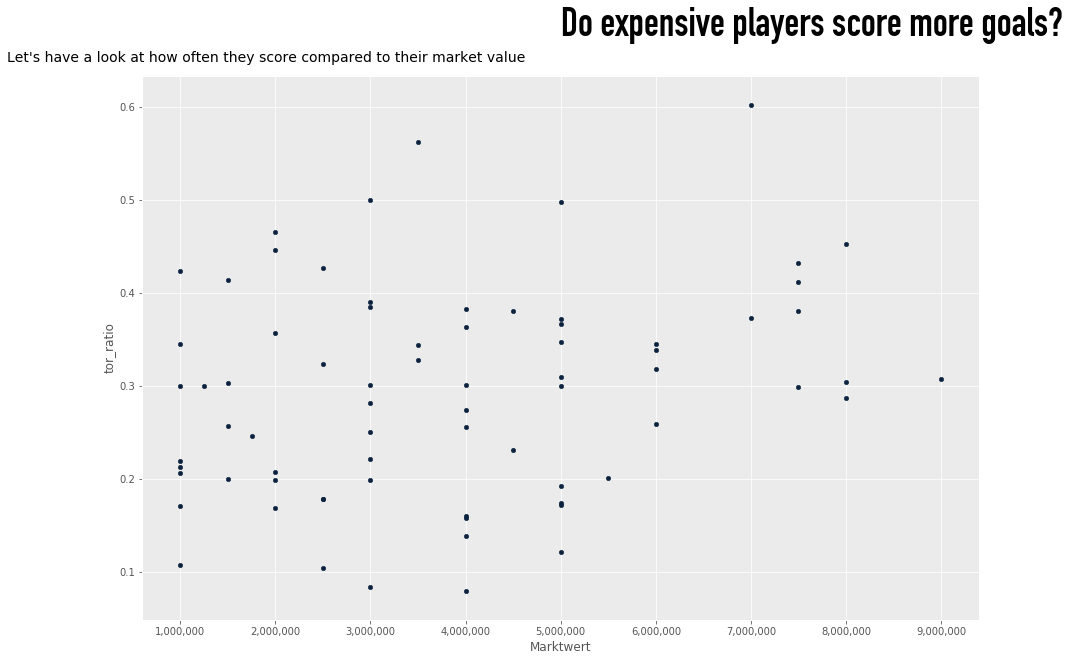

In [644]:
fig, ax = plt.subplots(figsize =(15,10))

#Font
csfont = {'fontname':'DIN Condensed'}

goalscorer.plot(x='Marktwert', y='tor_ratio', kind='scatter', ax = ax, color=['#0C2340'])
plt.axes

ax.set_facecolor("#EBEBEB")

#Title
ax.set_title("Do expensive players score more goals?", **csfont, pad=40, fontsize=40, ha="left")
plt.gcf().text(0.0, 0.9, "Let's have a look at how often they score compared to their market value", ha="left", fontsize=14)

#Formatting x-labels 
#Step 1: Build a function
def with_words(value, pos):
    millions = int(value/1000000)
   # print(pos)
    return "{} million".format(int(millions))

def with_commas(value, pos):
    return "{:,}".format(int(value))

#Step 2: Use FuncFormatter with that function
formatter = FuncFormatter(with_commas)
ax.set_axisbelow(True)

ax.xaxis.set_major_formatter(formatter)